In [3]:
from matplotlib import pyplot as plt
import os
import glob
import rasterio
import numpy as np

## Sentinel 1 sigma0
The Sentinel 1 satellite carries a Synthetic Aperture Radar (SAR) instrument on-board. This instrument sends radar pulses at a frequency of X Hz towards the Earth and records the backscattered intensity and polarization of the received signal. The intensity of the received signal indicates the surface roughness, ...[check some introduction S1 literature].

In a typical S1-SIGMA0 folder, we find 4 files: the backscatter intensity images (VV/VH), the incidence angle image, and a metadata XML file


In [4]:
os.listdir('/data/MTDA/CGS_S1/CGS_S1_GRD_SIGMA0_L1/2017/05/21/S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110/')

['S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110_angle.tif',
 'S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110.xml',
 'S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110_VH.tif',
 'S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110_VV.tif']

Read in the VV and VH backscatter intensity images for a predefined window, because reading in the entire image might result in memory issues.


In [5]:
indir = '/data/MTDA/CGS_S1/CGS_S1_GRD_SIGMA0_L1/2017/05/21/S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110/'

window = ((10000, 12500), (10000, 12500))

with rasterio.open(os.path.join(indir, 'S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110_VV.tif')) as src:
    VVdata = src.read(1, window=window)
with rasterio.open(os.path.join(indir, 'S1A_IW_GRDH_SIGMA0_DV_20170521T173234_ASCENDING_161_DBA1_V110_VH.tif')) as src:
    VHdata = src.read(1, window=window)  

The backscatter images are provided in original intensities, while we usually visualize radar data in decibels, due to the large range of values. Therefore, we convert the original values to decibels.

In [6]:
VVdataDB = 10*np.log10(VVdata)
VHdataDB = 10*np.log10(VHdata)

#### VV, VH, and VV/VH
While a typical optical image provides us with nice RGB bands, these Sentinel 1 SAR data only have two bands: VV and VH, the co-polarized and cross-polarized channels. The different behaviour of VV vs VH, however, is also a very useful polarimetric value. Therefore, we define a third variable as the ratio between the two.

In [7]:
VVVHratio = VVdataDB/VHdataDB

#### Visualization preparation
Together with the ratio, we now have three bands, so we can construct an RGB image. Let's rescale the data to our desired ranges for proper visualization:

VV: between -25 and +3 dB
VH: between -30 and -2 dB
ratio: between 0.4 and 1

In [16]:
# Define a simple rescale function
def rescale(data, minValue, maxValue):
    return (data - minValue)/(maxValue - minValue)

# Do the rescaling
VVdataDBnorm = rescale(VVdataDB, -25, 3)
VHdataDBnorm = rescale(VHdataDB, -30, -2)
VVVHrationorm = rescale(VVVHratio, 0.4, 1)

#### Visualization 
Visualization of the three bands (VV, VH polarization, and the ratio of the two) using RGB stacking gives the result below. Cities and villages, with their larger anisotropic nature, appear as yellow-brown areas, while cultivated land appears as blue or red areas. The difference between land being indicated as blue or red is connected to...[check with Kristof].

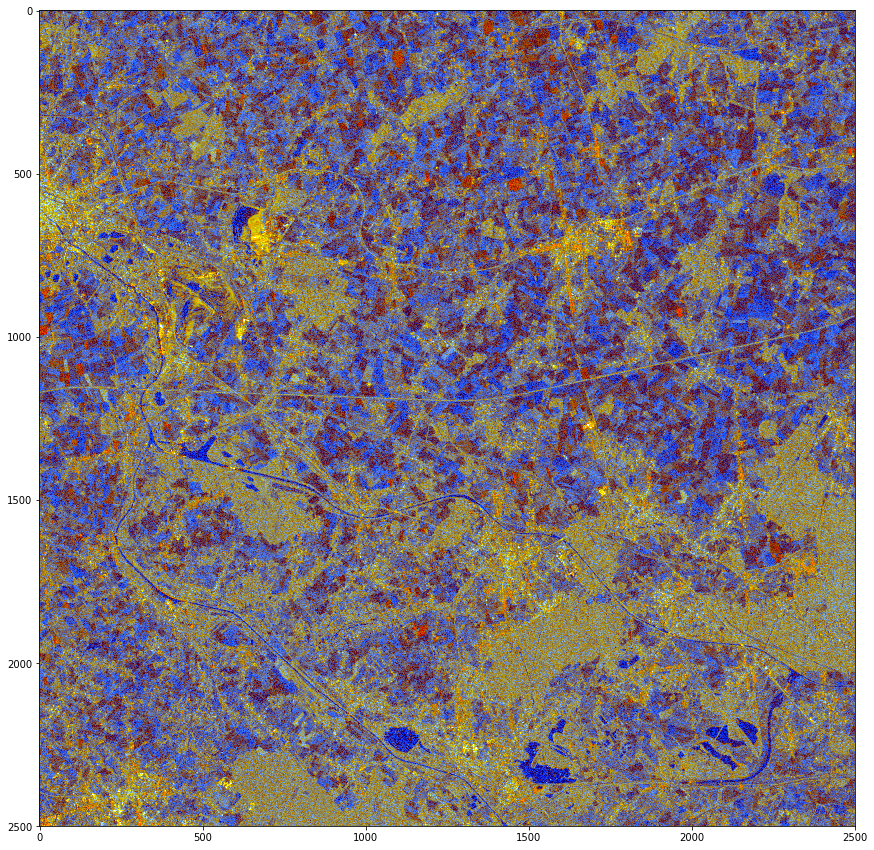

In [17]:
rgb = np.concatenate((np.expand_dims(VVdataDBnorm, axis=2),
                      np.expand_dims(VHdataDBnorm, axis=2),
                      np.expand_dims(VVVHrationorm, axis=2)), axis=2)

plt.figure(figsize=(15,15))
plt.imshow(rgb)
